In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import keras
import re

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import OneClassSVM, SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, plot_confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences

from imblearn.over_sampling import RandomOverSampler
import pickle

import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
import gensim
from gensim.parsing.preprocessing import remove_stopwords
stopwords = gensim.parsing.preprocessing.STOPWORDS

[nltk_data] Downloading package punkt to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def clean(line):
    line = re.sub(r'[0-9\.]+', '', line) # remove digits
    line = re.sub(r'[^\w\s]','', line) # remove punctuation
    return line

def stemming(line):
    stemmer = SnowballStemmer(language='english')
    return [stemmer.stem(token) for token in line]

def lemmatization(line):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in line]

def remove_stop_words(line):
    return [remove_stopwords(token) for token in line]

def pre_processing(line):
    tokenizer = TreebankWordTokenizer()

    tokenized_line = tokenizer.tokenize(clean(line))
    preprocessed_line = stemming(lemmatization(remove_stop_words(tokenized_line)))
    
    return ' '.join([token for token in preprocessed_line if token != ''])

## Attribute 14 Test

In [5]:
df = pd.read_csv('training_datasets/ghg_labelled.csv')

In [6]:
df.head()

,words,GT
0,Definition of Science Based Targets (SBTi) Wit...,1
1,LOOKING AHEAD Befimmo aims to provide quantita...,1
2,Target: fully aligned by 2023 DESCRIPTION AND ...,1
3,The TCFD structured its recommendations around...,0
4,More details on the TCFD framework and impleme...,1


In [7]:
df['words'] = df['words'].apply(lambda x: pre_processing(x))

In [8]:
df

,words,GT
0,definit scienc base target sbti with help sbti...,1
1,look ahead befimmo aim provid quantit disclosu...,1
2,target fulli align descript and approach in be...,1
3,the tcfd structur recommend theme govern strat...,0
4,more detail tcfd framework implement recommend...,1
...,...,...
746,indirect ghg emiss relat use custom energi pro...,0
747,improv detect measur satellit totalenergi part...,0
748,as transport generat approxim global ghg emiss,0
749,the compani follow oil gas industri report gui...,1


In [9]:
len(df)

751

In [10]:
len(df[df['GT'] == 1])

355

In [11]:
X = df['words']

In [12]:
y = df['GT']

### Word Embedding

In [13]:
X = X.apply(lambda x: x.lower())

In [14]:
X

0      definit scienc base target sbti with help sbti...
1      look ahead befimmo aim provid quantit disclosu...
2      target fulli align descript and approach in be...
3      the tcfd structur recommend theme govern strat...
4      more detail tcfd framework implement recommend...
                             ...                        
746    indirect ghg emiss relat use custom energi pro...
747    improv detect measur satellit totalenergi part...
748       as transport generat approxim global ghg emiss
749    the compani follow oil gas industri report gui...
750    ghg yoto protocol carbon dioxid co the gas nam...
Name: words, Length: 751, dtype: object

In [15]:
tfidf = TfidfVectorizer()

In [16]:
x = tfidf.fit_transform(X)

In [17]:
X_encoded = pd.DataFrame(x.toarray())

### Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [19]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854
131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.162961,0.0,0.0,0.0
673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.214761,0.0,0.0,0.0
106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193397,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [21]:
y_train.value_counts()

0    318
1    282
Name: GT, dtype: int64

### Logistic Regression

In [106]:
model1 = LogisticRegression(random_state=42)
model1.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [107]:
y_pred = model1.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


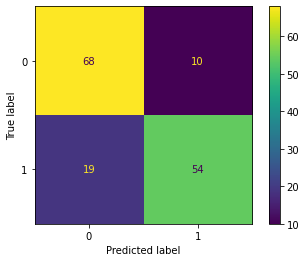

In [108]:
plot_confusion_matrix(model1, X_test, y_test)

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82        78
           1       0.84      0.74      0.79        73

    accuracy                           0.81       151
   macro avg       0.81      0.81      0.81       151
weighted avg       0.81      0.81      0.81       151



In [110]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8079470198675497
0.84375
0.7397260273972602
0.7883211678832116


In [111]:
lr_pred = y_pred

## Random Forest

In [42]:
param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 16],
 'min_samples_split': [2, 4, 6, 8, 10],
 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

In [43]:
model2 = RandomForestClassifier()

In [44]:
random_search = RandomizedSearchCV(estimator = model2, param_distributions = param_grid,  n_iter = 100, cv = 3, verbose=2, random_state=42, scoring='f1')

In [45]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=30; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=30; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=30; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=80; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=80; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=80; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=6, n_estimators=20; total t

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=16, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=16, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=16, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=2, n_estimators=80; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=2, n_estimators=80; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=6, n_estimators=90; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=6, n_estimators=90; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=80; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=80; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=80; total time=   0.1s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=40, max_f

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=90; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=90; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=40; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=40; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=40; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=8, n_estimators=40; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=8, n_estimators=40; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_fe

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8, 16],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, scoring='f1', verbose=2)

In [46]:
res_dict = random_search.best_params_
res_dict

{'n_estimators': 50,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': True}

In [47]:
model2 = RandomForestClassifier(n_estimators=res_dict['n_estimators'], min_samples_split=res_dict['min_samples_split'], 
                                min_samples_leaf=res_dict['min_samples_leaf'], bootstrap=res_dict['bootstrap'], 
                                max_depth = res_dict['max_depth'], random_state=42)

In [48]:
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


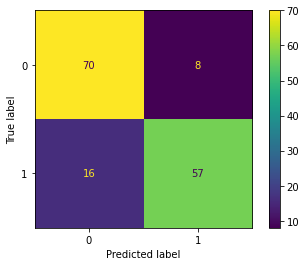

In [49]:
plot_confusion_matrix(model2, X_test, y_test)

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85        78
           1       0.88      0.78      0.83        73

    accuracy                           0.84       151
   macro avg       0.85      0.84      0.84       151
weighted avg       0.84      0.84      0.84       151



In [51]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8410596026490066
0.8769230769230769
0.7808219178082192
0.8260869565217391


In [52]:
rf_pred = y_pred

## LSTM

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
max_words = 1000
max_len = 100
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
seq = tok.texts_to_sequences(X_train)
seq_matrix = pad_sequences(seq, maxlen=max_len)

In [57]:
model3 = Sequential()
model3.add(Embedding(1000, 64, input_length=100))
model3.add(LSTM(64, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

In [58]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           64000     
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4

In [59]:
model3.fit(seq_matrix, y_train, batch_size=32, epochs=25)

Epoch 1/25
19/19 [==============================] - 6s 87ms/step - loss: 0.6929 - accuracy: 0.5167
Epoch 2/25
19/19 [==============================] - 2s 99ms/step - loss: 0.6900 - accuracy: 0.5300
Epoch 3/25
19/19 [==============================] - 2s 96ms/step - loss: 0.6584 - accuracy: 0.5567
Epoch 4/25
19/19 [==============================] - 2s 102ms/step - loss: 0.5249 - accuracy: 0.8467
Epoch 5/25
19/19 [==============================] - 2s 103ms/step - loss: 2917274.2500 - accuracy: 0.9000
Epoch 6/25
19/19 [==============================] - 2s 107ms/step - loss: 0.2043 - accuracy: 0.9217
Epoch 7/25
19/19 [==============================] - 2s 107ms/step - loss: 0.1311 - accuracy: 0.9533
Epoch 8/25
19/19 [==============================] - 2s 97ms/step - loss: 0.0992 - accuracy: 0.9700
Epoch 9/25
19/19 [==============================] - 2s 92ms/step - loss: 0.0773 - accuracy: 0.9750
Epoch 10/25
19/19 [==============================] - 2s 91ms/step - loss: 0.0705 - accuracy: 0.9783

In [60]:
test_seq = tok.texts_to_sequences(X_test)
test_seq_matrix = pad_sequences(test_seq,maxlen=max_len)

In [61]:
score = model3.evaluate(test_seq_matrix, y_test)

5/5 [==============================] - 1s 27ms/step - loss: 1.2672 - accuracy: 0.7815


In [62]:
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.2672055959701538
Test accuracy: 0.7814569473266602


In [63]:
test_seq_matrix

array([[  0,   0,   0, ..., 664, 114, 306],
       [  0,   0,   0, ...,  15, 290,  75],
       [  0,   0,   0, ...,  17,   2, 602],
       ...,
       [  0,   0,   0, ...,  23,   1,   2],
       [  0,   0,   0, ..., 777,  97,  16],
       [  0,   0,   0, ..., 155, 110, 637]])

In [64]:
pred = model3.predict(test_seq_matrix)

5/5 [==============================] - 1s 25ms/step


In [65]:
pred

array([[9.99224842e-01],
       [9.99729097e-01],
       [9.98455167e-01],
       [1.00000000e+00],
       [1.15527073e-03],
       [9.91841137e-01],
       [9.99998987e-01],
       [9.99980867e-01],
       [9.98434603e-01],
       [9.99979198e-01],
       [4.15961817e-03],
       [4.04218823e-04],
       [9.97785568e-01],
       [6.02186192e-04],
       [6.63632760e-04],
       [9.95214939e-01],
       [1.03455911e-08],
       [9.99999285e-01],
       [9.98978913e-01],
       [9.05606139e-04],
       [9.83722210e-01],
       [8.38780344e-01],
       [9.96969700e-01],
       [9.98759270e-01],
       [9.99948740e-01],
       [2.24009971e-04],
       [2.66722113e-01],
       [5.28589785e-01],
       [1.49266266e-09],
       [1.06397388e-03],
       [9.99999464e-01],
       [9.96586323e-01],
       [1.12457166e-03],
       [9.97889459e-01],
       [9.99996424e-01],
       [9.97819722e-01],
       [1.12630034e-04],
       [9.98970211e-01],
       [2.89827130e-06],
       [9.97723281e-01],


In [66]:
y_pred = np.where(pred < 0.5, 0, 1)

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78        78
           1       0.76      0.81      0.78        73

    accuracy                           0.78       151
   macro avg       0.78      0.78      0.78       151
weighted avg       0.78      0.78      0.78       151



In [70]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.7814569536423841
0.7564102564102564
0.8082191780821918
0.781456953642384


In [72]:
lstm_pred = y_pred

### Using Tfidf

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [74]:
X_train.shape

(600, 1855)

In [75]:
model3 = Sequential()
model3.add(Embedding(256, 64, input_length=X_train.shape[1]))
model3.add(LSTM(64, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [45]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2906, 64)          16384     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 57,857
Trainable params: 57,857
Non-trainable params: 0
_________________________________________________________________


In [46]:
#model3.fit(X_train, y_train, batch_size=64, epochs=20)

In [47]:
#score = model3.evaluate(X_test, y_test)

In [48]:
#print("Test loss:", score[0])
#print("Test accuracy:", score[1])

In [49]:
#pred = model3.predict(X_test)
#y_pred = np.where(pred < 0.5, 0, 1)

In [50]:
#y_pred

In [51]:
#print(classification_report(y_test, y_pred))

### AdaBoost

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [77]:
ada = AdaBoostClassifier(random_state=42)

In [78]:
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.1, 0.2, 0.5, 0.8, 1.0, 10]
}

In [79]:
random_search = RandomizedSearchCV(estimator = ada, param_distributions = param_grid,  n_iter = 100, cv = 3, verbose=2, random_state=42, scoring='f1')

In [80]:
random_search.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.1s
[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.1s
[CV] END .................learning_rate=0.1, n_estimators=20; total time=   0.3s
[CV] END .................learning_rate=0.1, n_estimators=20; total time=   0.3s
[CV] END .................learning_rate=0.1, n_estimators=20; total time=   0.3s
[CV] END .................learning_rate=0.1, n_estimators=30; total time=   0.3s
[CV] END .................learning_rate=0.1, n_estimators=30; total time=   0.3s
[CV] END .................learning_rate=0.1, n_estimators=30; total time=   0.4s
[CV] END .................learning_rate=0.1, n_estimators=40; total time=   0.5s
[CV] END .................learning_rate=0.1, n_estimators=40; total time=   0.4s
[CV] END .................learning_rate=0.1, n_

[CV] END .................learning_rate=0.8, n_estimators=40; total time=   0.6s
[CV] END .................learning_rate=0.8, n_estimators=50; total time=   0.7s
[CV] END .................learning_rate=0.8, n_estimators=50; total time=   0.7s
[CV] END .................learning_rate=0.8, n_estimators=50; total time=   0.7s
[CV] END .................learning_rate=0.8, n_estimators=60; total time=   1.4s
[CV] END .................learning_rate=0.8, n_estimators=60; total time=   1.8s
[CV] END .................learning_rate=0.8, n_estimators=60; total time=   1.3s
[CV] END .................learning_rate=0.8, n_estimators=70; total time=   1.6s
[CV] END .................learning_rate=0.8, n_estimators=70; total time=   1.3s
[CV] END .................learning_rate=0.8, n_estimators=70; total time=   1.8s
[CV] END .................learning_rate=0.8, n_estimators=80; total time=   1.6s
[CV] END .................learning_rate=0.8, n_estimators=80; total time=   1.7s
[CV] END .................le

RandomizedSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.5, 0.8,
                                                          1.0, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, scoring='f1', verbose=2)

In [81]:
res_dict = random_search.best_params_
res_dict

{'n_estimators': 20, 'learning_rate': 1.0}

In [82]:
ada = AdaBoostClassifier(n_estimators = res_dict['n_estimators'], learning_rate = res_dict['learning_rate'], 
                        random_state=42)

In [83]:
ada.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=20, random_state=42)

In [84]:
y_pred = ada.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


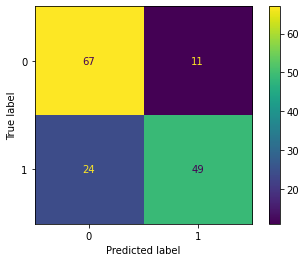

In [85]:
plot_confusion_matrix(ada, X_test, y_test)

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.86      0.79        78
           1       0.82      0.67      0.74        73

    accuracy                           0.77       151
   macro avg       0.78      0.77      0.76       151
weighted avg       0.78      0.77      0.77       151



In [88]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.7682119205298014
0.8166666666666667
0.6712328767123288
0.7368421052631579


In [87]:
ada_pred = y_pred

### BERTQA

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

In [ ]:
model_name = "deepset/roberta-base-squad2"
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)

In [ ]:
ones = df[df['GT'] == 1]

In [67]:
ones

,words,GT
0,Definition of Science Based Targets (SBTi) Wit...,1
1,LOOKING AHEAD Befimmo aims to provide quantita...,1
2,Target: fully aligned by 2023 DESCRIPTION AND ...,1
4,More details on the TCFD framework and impleme...,1
5,Our ESG journey Our 2030 commitments Performan...,1
...,...,...
743,To calculate the aforementioned scope 3 emissi...,1
744,We do not have oil and gas reserves in areas c...,1
745,This Sustainability & Climate 2022 Progress Re...,1
749,The Company follows the oil & gas industry rep...,1


In [65]:
ones.to_csv('ghg_checked.csv', index=False)

In [66]:
ones

,words,GT
0,Definition of Science Based Targets (SBTi) Wit...,1
1,LOOKING AHEAD Befimmo aims to provide quantita...,1
2,Target: fully aligned by 2023 DESCRIPTION AND ...,1
4,More details on the TCFD framework and impleme...,1
5,Our ESG journey Our 2030 commitments Performan...,1
...,...,...
743,To calculate the aforementioned scope 3 emissi...,1
744,We do not have oil and gas reserves in areas c...,1
745,This Sustainability & Climate 2022 Progress Re...,1
749,The Company follows the oil & gas industry rep...,1


In [70]:
ones['keywords'] = None

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_9860\3832277006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ones['keywords'] = None


In [71]:
ones

,words,GT,keywords
0,Definition of Science Based Targets (SBTi) Wit...,1,None
1,LOOKING AHEAD Befimmo aims to provide quantita...,1,None
2,Target: fully aligned by 2023 DESCRIPTION AND ...,1,None
4,More details on the TCFD framework and impleme...,1,None
5,Our ESG journey Our 2030 commitments Performan...,1,None
...,...,...,...
743,To calculate the aforementioned scope 3 emissi...,1,None
744,We do not have oil and gas reserves in areas c...,1,None
745,This Sustainability & Climate 2022 Progress Re...,1,None
749,The Company follows the oil & gas industry rep...,1,None


In [95]:
ones['words'][0]

'Definition of Science Based Targets (SBTi) With the help of SBTi and following the complete revision of its carbon footprint in accordance with the GHG Protocol.'

In [109]:
from keybert import KeyBERT
from tqdm.notebook import tqdm

In [110]:
bert=KeyBERT()

In [111]:
kw = []
for i in tqdm(ones['words']):
    kw.append(bert.extract_keywords(i, keyphrase_ngram_range=(1, 1), stop_words='english'))

  0%|          | 0/355 [00:00<?, ?it/s]

In [113]:
ones['kw'] = kw

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_9860\4824665.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ones['kw'] = kw


In [114]:
ones

,words,GT,keywords,kw
0,Definition of Science Based Targets (SBTi) Wit...,1,"['GHG', 'SBTi', 'TCFD', 'SASB']","[(sbti, 0.4794), (targets, 0.4196), (science, ..."
1,LOOKING AHEAD Befimmo aims to provide quantita...,1,"['SBTi', 'TCFD', 'SASB']","[(befimmo, 0.4072), (climate, 0.3598), (tcfd, ..."
2,Target: fully aligned by 2023 DESCRIPTION AND ...,1,"['SBTi', 'TCFD', 'SASB']","[(tcfd, 0.4205), (befimmo, 0.3972), (2021, 0.3..."
4,More details on the TCFD framework and impleme...,1,"['SBTi', 'TCFD', 'SASB']","[(tcfd, 0.6651), (framework, 0.4223), (impleme..."
5,Our ESG journey Our 2030 commitments Performan...,1,"['SBTi', 'TCFD', 'SASB']","[(kpis, 0.4649), (esg, 0.3891), (tcfd, 0.3596)..."
...,...,...,...,...
743,To calculate the aforementioned scope 3 emissi...,1,"['GHG', 'SBTi', 'TCFD', 'SASB']","[(emissions, 0.6148), (scope, 0.3511), (produc..."
744,We do not have oil and gas reserves in areas c...,1,"['SBTi', 'TCFD', 'SASB']","[(indigenous, 0.3091), (reserves, 0.3001), (la..."
745,This Sustainability & Climate 2022 Progress Re...,1,"['SBTi', 'TCFD', 'SASB']","[(2021, 0.4623), (2022, 0.4578), (tcfd1, 0.431..."
749,The Company follows the oil & gas industry rep...,1,"['GHG', 'SBTi', 'TCFD', 'SASB']","[(ipieca, 0.389), (guidelines, 0.3779), (ghg, ..."


In [121]:
'sbti' in ones['kw'][0]

False

In [133]:
for index, rows in ones.iterrows():
    res = []
    if ('ghg' in rows['words'].lower()) or (r'scope \d' in rows['words'].lower()):
        res.append('GHG')
    if ('sbti' in rows['words'].lower()) or ('science based targets' in rows['words'].lower()):
        res.append('SBTi')
    if ('tcfd' in rows['words'].lower()) or ('climate-related financial disclosures' in rows['words'].lower()):
        res.append('TCFD')
    if ('sasb' in rows['words'].lower()) or ('sustainability accounting' in rows['words'].lower()):
        res.append('SASB')
    
    print(res)
    ones.at[index, 'keywords'] = str(res)

['GHG', 'SBTi']
['TCFD']
['TCFD']
['TCFD']
['TCFD', 'SASB']
['SASB']
['GHG']
['GHG']
['GHG']
['GHG']
['GHG']
['GHG']
['GHG']
['GHG']
['GHG', 'SBTi']
['GHG']
['SBTi']
['SBTi']
['GHG']
['TCFD', 'SASB']
['TCFD', 'SASB']
['SBTi']
['TCFD', 'SASB']
['TCFD', 'SASB']
['TCFD', 'SASB']
['TCFD']
['TCFD']
['SBTi']
['SBTi']
['GHG', 'SBTi']
['GHG']
['GHG', 'SBTi']
['SBTi']
['TCFD']
['TCFD']
['SBTi']
['GHG']
['GHG', 'TCFD', 'SASB']
['GHG']
['SBTi']
['GHG']
['SBTi']
['GHG']
['SBTi']
['TCFD', 'SASB']
['SASB']
['GHG']
['GHG']
['GHG']
['GHG']
['GHG']
['GHG']
['GHG', 'TCFD', 'SASB']
['GHG']
['SBTi']
['SBTi']
['TCFD']
['TCFD']
['GHG']
['GHG']
['GHG']
['SBTi']
['TCFD']
['TCFD']
['TCFD']
['TCFD']
['GHG']
['TCFD']
['TCFD']
['TCFD']
['TCFD']
['TCFD']
['TCFD']
['SBTi']
['TCFD']
['GHG']
['TCFD']
['SASB']
['GHG']
['GHG']
['TCFD', 'SASB']
['GHG']
['GHG']
['SBTi']
['GHG']
['SASB']
['SASB']
['GHG', 'TCFD']
['TCFD']
['TCFD']
['TCFD']
['GHG']
['GHG']
['GHG']
['GHG']
['TCFD']
['TCFD']
['GHG', 'TCFD']
['GHG']
['TCFD']
[

In [132]:
ones

,words,GT,keywords,kw
0,Definition of Science Based Targets (SBTi) Wit...,1,"['GHG', 'SBTi']","[(sbti, 0.4794), (targets, 0.4196), (science, ..."
1,LOOKING AHEAD Befimmo aims to provide quantita...,1,['TCFD'],"[(befimmo, 0.4072), (climate, 0.3598), (tcfd, ..."
2,Target: fully aligned by 2023 DESCRIPTION AND ...,1,['TCFD'],"[(tcfd, 0.4205), (befimmo, 0.3972), (2021, 0.3..."
4,More details on the TCFD framework and impleme...,1,['TCFD'],"[(tcfd, 0.6651), (framework, 0.4223), (impleme..."
5,Our ESG journey Our 2030 commitments Performan...,1,"['TCFD', 'SASB']","[(kpis, 0.4649), (esg, 0.3891), (tcfd, 0.3596)..."
...,...,...,...,...
743,To calculate the aforementioned scope 3 emissi...,1,['GHG'],"[(emissions, 0.6148), (scope, 0.3511), (produc..."
744,We do not have oil and gas reserves in areas c...,1,['SASB'],"[(indigenous, 0.3091), (reserves, 0.3001), (la..."
745,This Sustainability & Climate 2022 Progress Re...,1,['TCFD'],"[(2021, 0.4623), (2022, 0.4578), (tcfd1, 0.431..."
749,The Company follows the oil & gas industry rep...,1,['GHG'],"[(ipieca, 0.389), (guidelines, 0.3779), (ghg, ..."


In [65]:
res = []
q1 = 'Which target was applied?'
q2 = 'Which protocol was applied?'
q3 = 'What methodology was applied?'
q4 = 'What recommendations was applied?'
for i in ones['words']:
    QA_1 = {
        'question': q1,
        'context': i
    }
    QA_2 = {
        'question': q2,
        'context': i
    }
    QA_3 = {
        'question': q3,
        'context': i
    }
    QA_4 = {
        'question': q4,
        'context': i
    }
    
    ans1 = nlp(QA_1)['answer']
    score1 = nlp(QA_1)['score']
    ans2 = nlp(QA_2)['answer']
    score2 = nlp(QA_2)['score']
    ans3 = nlp(QA_3)['answer']
    score3 = nlp(QA_3)['score']
    ans4 = nlp(QA_4)['answer']
    score4 = nlp(QA_4)['score']
    
    maxi = max([score1, score2, score3, score4])
    if maxi == score1:
        res.append(ans1)
    elif maxi == score2:
        res.append(ans2)
    elif maxi == score4:
        res.append(ans4)
    else:
        res.append(ans3)
    

In [66]:
ones['answer'] = np.array(res)

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_1580\612445749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ones['answer'] = np.array(res)


In [67]:
ones

,words,GT,answer
0,Definition of Science Based Targets (SBTi) Wit...,1,GHG Protocol
1,LOOKING AHEAD Befimmo aims to provide quantita...,1,TCFD
2,Target: fully aligned by 2023 DESCRIPTION AND ...,1,Task Force on Climate-Related Financial Disclo...
4,More details on the TCFD framework and impleme...,1,recommendations
5,Our ESG journey Our 2030 commitments Performan...,1,Net Zero carbon Place based approach
...,...,...,...
743,To calculate the aforementioned scope 3 emissi...,1,GHG Protocol
744,We do not have oil and gas reserves in areas c...,1,do not have oil and gas reserves in areas clos...
745,This Sustainability & Climate 2022 Progress Re...,1,2021
749,The Company follows the oil & gas industry rep...,1,GHG Protocol


In [68]:
ones['answer'].str.lower().str.contains('ghg|tcfd|task force on climate-related financial disclosure|sbti|science-based|sasb').sum()

175

### One Class SVM

In [89]:
ocsvm = SVC()

In [90]:
param_grid = {
    'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": np.arange(0.1, 1, 0.1)
}

In [91]:
random_search = RandomizedSearchCV(estimator = ocsvm, param_distributions = param_grid,  n_iter = 100, 
                                   cv = 3, verbose=2, random_state=42, scoring='f1')

In [92]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ......C=7, gamma=0.30000000000000004, kernel=linear; total time=   0.1s
[CV] END ......C=7, gamma=0.30000000000000004, kernel=linear; total time=   0.1s
[CV] END ......C=7, gamma=0.30000000000000004, kernel=linear; total time=   0.1s
[CV] END .........................C=2, gamma=0.2, kernel=rbf; total time=   0.2s
[CV] END .........................C=2, gamma=0.2, kernel=rbf; total time=   0.2s
[CV] END .........................C=2, gamma=0.2, kernel=rbf; total time=   0.2s
[CV] END ........................C=8, gamma=0.9, kernel=poly; total time=   0.2s
[CV] END ........................C=8, gamma=0.9, kernel=poly; total time=   0.2s
[CV] END ........................C=8, gamma=0.9, kernel=poly; total time=   0.2s
[CV] END .........................C=9, gamma=0.4, kernel=rbf; total time=   0.3s
[CV] END .........................C=9, gamma=0.4, kernel=rbf; total time=   0.3s
[CV] END .........................C=9, gamma=0

[CV] END ......................C=5, gamma=0.2, kernel=linear; total time=   0.1s
[CV] END ........................C=4, gamma=0.2, kernel=poly; total time=   0.1s
[CV] END ........................C=4, gamma=0.2, kernel=poly; total time=   0.1s
[CV] END ........................C=4, gamma=0.2, kernel=poly; total time=   0.1s
[CV] END .....................C=2, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=2, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=2, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .........................C=1, gamma=0.6, kernel=rbf; total time=   0.2s
[CV] END .........................C=1, gamma=0.6, kernel=rbf; total time=   0.2s
[CV] END .........................C=1, gamma=0.6, kernel=rbf; total time=   0.2s
[CV] END .....C=10, gamma=0.7000000000000001, kernel=sigmoid; total time=   0.1s
[CV] END .....C=10, gamma=0.7000000000000001, kernel=sigmoid; total time=   0.1s
[CV] END .....C=10, gamma=0.

[CV] END ........C=10, gamma=0.30000000000000004, kernel=rbf; total time=   0.2s
[CV] END ........C=10, gamma=0.30000000000000004, kernel=rbf; total time=   0.2s
[CV] END ........C=10, gamma=0.30000000000000004, kernel=rbf; total time=   0.2s
[CV] END ........................C=3, gamma=0.6, kernel=poly; total time=   0.1s
[CV] END ........................C=3, gamma=0.6, kernel=poly; total time=   0.1s
[CV] END ........................C=3, gamma=0.6, kernel=poly; total time=   0.1s
[CV] END .........................C=6, gamma=0.5, kernel=rbf; total time=   0.2s
[CV] END .........................C=6, gamma=0.5, kernel=rbf; total time=   0.2s
[CV] END .........................C=6, gamma=0.5, kernel=rbf; total time=   0.2s
[CV] END ........................C=6, gamma=0.5, kernel=poly; total time=   0.2s
[CV] END ........................C=6, gamma=0.5, kernel=poly; total time=   0.1s
[CV] END ........................C=6, gamma=0.5, kernel=poly; total time=   0.1s
[CV] END ...................

RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=100,
                   param_distributions={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                        'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=42, scoring='f1', verbose=2)

In [93]:
res_dict = random_search.best_params_
res_dict

{'kernel': 'sigmoid', 'gamma': 0.5, 'C': 2}

In [94]:
ocsvm = SVC(C = res_dict['C'], kernel = res_dict['kernel'], gamma=res_dict['gamma'])

In [95]:
ocsvm.fit(X_train, y_train)

SVC(C=2, gamma=0.5, kernel='sigmoid')

In [96]:
y_pred = ocsvm.predict(X_test)

In [97]:
y_pred

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
      dtype=int64)

In [98]:
y_pred = np.vectorize(lambda x: 0 if x == -1 else x)(y_pred)

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        78
           1       0.85      0.78      0.81        73

    accuracy                           0.83       151
   macro avg       0.83      0.83      0.83       151
weighted avg       0.83      0.83      0.83       151



In [100]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8278145695364238
0.8507462686567164
0.7808219178082192
0.8142857142857143


In [104]:
ocsvm_pred = y_pred

In [112]:
res = pd.DataFrame([lr_pred, rf_pred, ocsvm_pred]).transpose()

In [113]:
res

,0,1,2
0,1,1,1
1,1,1,1
2,1,0,1
3,1,1,1
4,0,0,0
...,...,...,...
146,0,0,0
147,0,0,0
148,0,0,0
149,0,0,0


In [114]:
res

,0,1,2
0,1,1,1
1,1,1,1
2,1,0,1
3,1,1,1
4,0,0,0
...,...,...,...
146,0,0,0
147,0,0,0
148,0,0,0
149,0,0,0


In [115]:
res['total'] = res.mode(axis=1)[0]

In [116]:
res['total']

0      1
1      1
2      1
3      1
4      0
      ..
146    0
147    0
148    0
149    0
150    0
Name: total, Length: 151, dtype: int64

In [117]:
res

,0,1,2,total
0,1,1,1,1
1,1,1,1,1
2,1,0,1,1
3,1,1,1,1
4,0,0,0,0
...,...,...,...,...
146,0,0,0,0
147,0,0,0,0
148,0,0,0,0
149,0,0,0,0


In [118]:
print(accuracy_score(y_test, res['total']))
print(precision_score(y_test, res['total']))
print(recall_score(y_test, res['total']))
print(f1_score(y_test, res['total']))

0.8211920529801324
0.859375
0.7534246575342466
0.8029197080291972


In [346]:
lr_14 = 'lr_14_model.sav'
rf_14 = 'rf_14_model.sav'
ada_14 = 'ada_14_model.sav'
tfidf_14 = 'tfidf_14_model.sav'
svc_14 = 'svc_14_model.pkl'

In [347]:
pickle.dump(tfidf, open(tfidf_14, 'wb'))

In [348]:
pickle.dump(model1, open(lr_14, 'wb'))

In [349]:
pickle.dump(model2, open(rf_14, 'wb'))
pickle.dump(ocsvm, open(svc_14, 'wb'))

## Attribute 15 Test

In [121]:
df_ext = pd.read_csv('training_datasets/ext_labelled.csv')

In [122]:
df_ext

,words,GT
0,Compliance with and implementation of the BMW ...,0
1,"In addition, we want to foster transparency in...",0
2,"In future, it will be possible to acknowledge ...",0
3,In collaboration with the RMI and the Chinese ...,0
4,The certified locations are audited by externa...,1
...,...,...
514,The Sustainable Development Office team Certai...,1
515,Please see the Limited Assurance Statement.,0
516,The results determine which suppliers need to ...,0
517,Please refer to the independent limited assura...,0


In [123]:
len(df_ext[df_ext['GT'] == 1])

78

In [124]:
df_ext_o = df_ext[df_ext['GT'] == 1]

In [125]:
df_ext_o.to_csv('ext_ones.csv', index=False)

In [126]:
df_ext['words'] = df_ext['words'].apply(lambda x: pre_processing(x))

In [127]:
df_ext

,words,GT
0,complianc implement bmw group legal complianc ...,0
1,in addit want foster transpar miner suppli cha...,0
2,in futur possibl acknowledg share result onsit...,0
3,in collabor rmi chines chamber commerc cccmc d...,0
4,the certifi locat audit extern certif organis,1
...,...,...
514,the sustain develop offic team certain data po...,1
515,pleas limit assur statement,0
516,the result determin supplier need audit ensur ...,0
517,pleas refer independ limit assur report detail,0


In [128]:
X = df_ext['words']
y = df_ext['GT']

### Word Embedding

In [129]:
X = X.apply(lambda x: x.lower())
X

0      complianc implement bmw group legal complianc ...
1      in addit want foster transpar miner suppli cha...
2      in futur possibl acknowledg share result onsit...
3      in collabor rmi chines chamber commerc cccmc d...
4          the certifi locat audit extern certif organis
                             ...                        
514    the sustain develop offic team certain data po...
515                          pleas limit assur statement
516    the result determin supplier need audit ensur ...
517       pleas refer independ limit assur report detail
518        descript qualiti assur process recal procedur
Name: words, Length: 519, dtype: object

In [130]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(X)
X_encoded = pd.DataFrame(x.toarray())

### Train Test Split

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [132]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458
433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201638,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
y_train.value_counts()

0    354
1     61
Name: GT, dtype: int64

In [134]:
ros = RandomOverSampler(sampling_strategy=1, random_state=42)

In [135]:
X_res, y_res = ros.fit_resample(X_train, y_train)

In [136]:
y_res.value_counts()

0    354
1    354
Name: GT, dtype: int64

In [137]:
y_test.value_counts()

0    87
1    17
Name: GT, dtype: int64

In [138]:
354+87

441

### Logistic Regression

In [139]:
model1 = LogisticRegression(random_state=42)
model1.fit(X_res, y_res)

LogisticRegression(random_state=42)

In [140]:
y_pred = model1.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


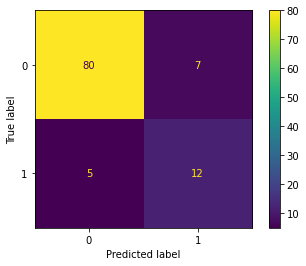

In [141]:
plot_confusion_matrix(model1, X_test, y_test)

In [142]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        87
           1       0.63      0.71      0.67        17

    accuracy                           0.88       104
   macro avg       0.79      0.81      0.80       104
weighted avg       0.89      0.88      0.89       104



In [143]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8846153846153846
0.631578947368421
0.7058823529411765
0.6666666666666667


In [126]:
lr_pred = y_pred

### Random Forest

In [144]:
param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 16],
 'min_samples_split': [2, 4, 6, 8, 10],
 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

In [145]:
model2 = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator = model2, param_distributions = param_grid,  
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, scoring='f1')
random_search.fit(X_res, y_res)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=30; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=30; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=30; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=80; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=80; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=80; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=6, n_estimators=20; total t

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.1s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=16, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=16, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=16, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=2, n_estimators=80; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=2, n_estimators=80; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=6, n_estimators=90; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=6, n_estimators=90; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=40; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=80; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=80; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=80; total time=   0.1s
[CV] END bootstrap=False, max_depth=40, max_f

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=90; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=90; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=90; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=40; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=40; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=40; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=8, n_estimators=40; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_fe

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8, 16],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, scoring='f1', verbose=2)

In [146]:
random_search.best_params_

{'n_estimators': 70,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [147]:
model2 = RandomForestClassifier(n_estimators=70, min_samples_split=2, min_samples_leaf=1, bootstrap=False, random_state=42)

In [148]:
model2.fit(X_res, y_res)
y_pred = model2.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


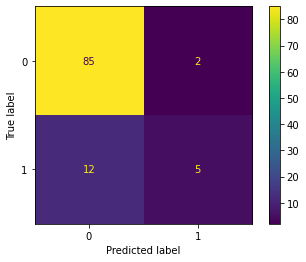

In [149]:
plot_confusion_matrix(model2, X_test, y_test)

In [150]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92        87
           1       0.71      0.29      0.42        17

    accuracy                           0.87       104
   macro avg       0.80      0.64      0.67       104
weighted avg       0.85      0.87      0.84       104



In [151]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8653846153846154
0.7142857142857143
0.29411764705882354
0.4166666666666667


In [152]:
rf_pred = y_pred

### LSTM

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [154]:
max_words = 1000
max_len = 100
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
seq = tok.texts_to_sequences(X_train)
seq_matrix = pad_sequences(seq, maxlen=max_len)

In [155]:
model3 = Sequential()
model3.add(Embedding(1000, 64, input_length=100))
model3.add(LSTM(64, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(632, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

In [156]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           64000     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 256)               16640     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [157]:
model3.fit(seq_matrix, y_train, batch_size=32, epochs=25)

Epoch 1/25
13/13 [==============================] - 4s 78ms/step - loss: 0.6086 - accuracy: 0.8482
Epoch 2/25
13/13 [==============================] - 1s 101ms/step - loss: 0.4228 - accuracy: 0.8530
Epoch 3/25
13/13 [==============================] - 1s 98ms/step - loss: 0.3769 - accuracy: 0.8530
Epoch 4/25
13/13 [==============================] - 1s 99ms/step - loss: 0.2958 - accuracy: 0.8530
Epoch 5/25
13/13 [==============================] - 1s 96ms/step - loss: 0.2216 - accuracy: 0.8530
Epoch 6/25
13/13 [==============================] - 1s 97ms/step - loss: 0.1764 - accuracy: 0.8530
Epoch 7/25
13/13 [==============================] - 1s 94ms/step - loss: 0.1417 - accuracy: 0.8675
Epoch 8/25
13/13 [==============================] - 1s 109ms/step - loss: 0.1266 - accuracy: 0.9663
Epoch 9/25
13/13 [==============================] - 1s 115ms/step - loss: 0.1208 - accuracy: 0.9783
Epoch 10/25
13/13 [==============================] - 1s 97ms/step - loss: 0.1085 - accuracy: 0.9783
Epoch 

In [158]:
test_seq = tok.texts_to_sequences(X_test)
test_seq_matrix = pad_sequences(test_seq,maxlen=max_len)

In [159]:
score = model3.evaluate(test_seq_matrix, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

4/4 [==============================] - 1s 23ms/step - loss: 8.0516 - accuracy: 0.8750
Test loss: 8.051630020141602
Test accuracy: 0.875


In [160]:
pred = model3.predict(test_seq_matrix)
y_pred = np.where(pred < 0.5, 0, 1)

4/4 [==============================] - 1s 22ms/step


In [161]:
confusion_matrix(y_test, y_pred)

array([[85,  2],
       [11,  6]], dtype=int64)

In [162]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        87
           1       0.75      0.35      0.48        17

    accuracy                           0.88       104
   macro avg       0.82      0.66      0.70       104
weighted avg       0.86      0.88      0.86       104



In [163]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.875
0.75
0.35294117647058826
0.48


In [145]:
lstm_pred = y_pred

### BERTQA

In [259]:
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

In [260]:
model_name = "deepset/roberta-base-squad2"
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)

In [261]:
ones = df_ext[df_ext['GT'] == 1]

In [262]:
ones

,words,GT
4,The certified locations are audited by external certification organisations.,1
5,"GRI 102-56 see Assurance Report With the exception of the auditors of the legislation-rele-vant information who were selected by the Supervisory Board of BMW AG the Corporate Reporting, Corporate Communications and Policy as well as Corporate Planning and Product Strategy departments selected the external auditors for the Sustainable Value Report.",1
7,"We conducted our assurance engagement in accordance with the Interna-tional Standard on Assurance Engagements (ISAE) 3000 (Revised): Assur-ance Engagements other than Audits or Reviews of Historical Financial Infor-mation, issued by the IAASB.",1
15,Tian LLP has provided limited assurance on selected key data in this Report.,1
18,"And the result will be audited by a third party, which is a key reference to grant the title.",1
...,...,...
471,"In addition, Deloitte assures key sustainability indicators and targets included in both our Annual Report and Sustainability Report, to the International Standard on Assurance Engagement 3000 (ISAE 3000).",1
472,Here we provide Deloitte LLPs limited assurance statement for our 2021 sustainability data.,1
473,The scope of our independent assurance and the data assured in 2021 is also shared in our Sustainability Basis of Reporting 2021.,1
511,Key performance data has been independently assured by Deloitte.,1


In [263]:
ones['words'][4]

'The certified locations are audited by external certification organisations.'

In [264]:
QA = {
    'question': 'who audited the targets?',
    'context': 'The certified locations are audited by external certification organisations.'
}

In [265]:
res = []
q1 = 'Who audited the targets?'
q2 = 'Who assured the targets?'
q3 = 'Who verified the targets?'
for i in ones['words']:
    QA_1 = {
        'question': q1,
        'context': i
    }
    QA_2 = {
        'question': q2,
        'context': i
    }
    QA_3 = {
        'question': q3,
        'context': i
    }
    
    ans1 = nlp(QA_1)['answer']
    score1 = nlp(QA_1)['score']
    ans2 = nlp(QA_2)['answer']
    score2 = nlp(QA_2)['score']
    ans3 = nlp(QA_3)['answer']
    score3 = nlp(QA_3)['score']
    
    maxi = max([score1, score2, score3])
    if maxi == score1:
        res.append(ans1)
    elif maxi == score2:
        res.append(ans2)
    else:
        res.append(ans3)
    

In [266]:
ones['answer'] = np.array(res)

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_1580\612445749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ones['answer'] = np.array(res)


In [267]:
ones.head(10)

,words,GT,answer
4,The certified locations are audited by external certification organisations.,1,external certification organisations
5,"GRI 102-56 see Assurance Report With the exception of the auditors of the legislation-rele-vant information who were selected by the Supervisory Board of BMW AG the Corporate Reporting, Corporate Communications and Policy as well as Corporate Planning and Product Strategy departments selected the external auditors for the Sustainable Value Report.",1,external auditors
7,"We conducted our assurance engagement in accordance with the Interna-tional Standard on Assurance Engagements (ISAE) 3000 (Revised): Assur-ance Engagements other than Audits or Reviews of Historical Financial Infor-mation, issued by the IAASB.",1,IAASB
15,Tian LLP has provided limited assurance on selected key data in this Report.,1,Tian LLP
18,"And the result will be audited by a third party, which is a key reference to grant the title.",1,a third party
25,All (100 percent) of Fords 2019 global facility GHG emissions will be third-party verified to a limited level of assurance in conformance with ISO -1:2018.,1,third-party
28,"As completed for 2018, 100 percent of Fords 2019 GHG emissions from our operations will be third-party verified to a limited level of assurance in accordance with ISO -3.",1,third-party
30,"To demonstrate our commitment to responsibly sourced copper, we have partnered with the Copper Mark, a new, comprehensive social and environmental assurance program.",1,Copper Mark
31,"For 2019, Stantec conducted limited independent assurance of operational management topics such as: waste, water, carbon and energy data for global facilities.",1,Stantec
32,See Stantecs full statement of assurance on page 171.,1,Stantecs


In [117]:
list(ones['answer'])

['external certification organisations',
 'external auditors',
 'IAASB',
 'Tian LLP',
 'a third party',
 'third-party',
 'third-party',
 'Copper Mark',
 'Stantec',
 'Stantecs',
 'Stantec',
 'Stantec',
 'Stantec',
 'Stantecs',
 'Stantec',
 'independent practitioners',
 'independent practitioners',
 'independent practitioners',
 'independent practitioners',
 'the management of HMC',
 'the client',
 'DNV GL',
 'an independent team of sustainability assurance professionals',
 'DNV GL',
 'DNV GL',
 'Lloyds Register Quality Assurance Ltd',
 'DNV GL',
 'DNV GLs',
 'DNV)',
 'DNV',
 'third-party assurance providers',
 'independent auditor',
 'independent auditor',
 'Grant Thornton',
 'Grant Thornton',
 'KPMG',
 'Ernst &Young Assurance Services SRL (EY Romania)',
 'independent limited assurance',
 'internal and external',
 'Independent Practitioner',
 'Independent Practitioner JSC "KPMG',
 'public assurance',
 'Deloitte',
 'Deloitte',
 'Deloitte LLP',
 'third-party',
 '2021',
 'LRQA',
 'PwC',
 '

In [118]:
ones['answer'].str.lower().str.contains('ghg|tcfd|task force on climate-related financial disclosure|sbti|science-based|sasb').sum()

1

### AdaBoost

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [165]:
ada = AdaBoostClassifier(random_state=42)

In [166]:
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.1, 0.2, 0.5, 0.8, 1.0, 10]
}

In [167]:
random_search = RandomizedSearchCV(estimator = ada, param_distributions = param_grid,  n_iter = 100, cv = 3, 
                                   verbose=2, random_state=42, scoring='f1')

In [168]:
random_search.fit(X_res, y_res)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=20; total time=   0.1s
[CV] END .................learning_rate=0.1, n_estimators=20; total time=   0.1s
[CV] END .................learning_rate=0.1, n_estimators=20; total time=   0.1s
[CV] END .................learning_rate=0.1, n_estimators=30; total time=   0.2s
[CV] END .................learning_rate=0.1, n_estimators=30; total time=   0.2s
[CV] END .................learning_rate=0.1, n_estimators=30; total time=   0.2s
[CV] END .................learning_rate=0.1, n_estimators=40; total time=   0.5s
[CV] END .................learning_rate=0.1, n_estimators=40; total time=   0.5s
[CV] END .................learning_rate=0.1, n_

[CV] END .................learning_rate=0.8, n_estimators=40; total time=   0.4s
[CV] END .................learning_rate=0.8, n_estimators=50; total time=   0.5s
[CV] END .................learning_rate=0.8, n_estimators=50; total time=   0.6s
[CV] END .................learning_rate=0.8, n_estimators=50; total time=   0.5s
[CV] END .................learning_rate=0.8, n_estimators=60; total time=   0.7s
[CV] END .................learning_rate=0.8, n_estimators=60; total time=   0.7s
[CV] END .................learning_rate=0.8, n_estimators=60; total time=   0.6s
[CV] END .................learning_rate=0.8, n_estimators=70; total time=   0.8s
[CV] END .................learning_rate=0.8, n_estimators=70; total time=   0.8s
[CV] END .................learning_rate=0.8, n_estimators=70; total time=   0.8s
[CV] END .................learning_rate=0.8, n_estimators=80; total time=   0.9s
[CV] END .................learning_rate=0.8, n_estimators=80; total time=   0.9s
[CV] END .................le

RandomizedSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.5, 0.8,
                                                          1.0, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, scoring='f1', verbose=2)

In [169]:
res_dict = random_search.best_params_
res_dict

{'n_estimators': 80, 'learning_rate': 0.5}

In [170]:
ada = AdaBoostClassifier(n_estimators = res_dict['n_estimators'], learning_rate = res_dict['learning_rate'], 
                        random_state=42)

In [171]:
ada.fit(X_res, y_res)

AdaBoostClassifier(learning_rate=0.5, n_estimators=80, random_state=42)

In [172]:
y_pred = ada.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


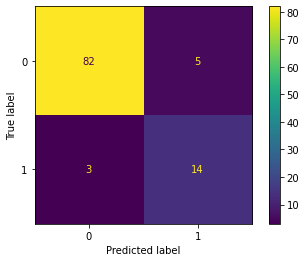

In [173]:
plot_confusion_matrix(ada, X_test, y_test)

In [174]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        87
           1       0.74      0.82      0.78        17

    accuracy                           0.92       104
   macro avg       0.85      0.88      0.87       104
weighted avg       0.93      0.92      0.92       104



In [175]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9230769230769231
0.7368421052631579
0.8235294117647058
0.7777777777777778


In [472]:
ada_pred = y_pred

### One Class SVM

In [176]:
ocsvm = SVC()

In [177]:
param_grid = {
    'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": np.arange(0.1, 1, 0.1)
}

In [178]:
random_search = RandomizedSearchCV(estimator = ocsvm, param_distributions = param_grid,  n_iter = 100, 
                                   cv = 3, verbose=2, random_state=42, scoring='f1')

In [179]:
random_search.fit(X_res, y_res)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ......C=7, gamma=0.30000000000000004, kernel=linear; total time=   0.0s
[CV] END ......C=7, gamma=0.30000000000000004, kernel=linear; total time=   0.0s
[CV] END ......C=7, gamma=0.30000000000000004, kernel=linear; total time=   0.0s
[CV] END .........................C=2, gamma=0.2, kernel=rbf; total time=   0.0s
[CV] END .........................C=2, gamma=0.2, kernel=rbf; total time=   0.1s
[CV] END .........................C=2, gamma=0.2, kernel=rbf; total time=   0.0s
[CV] END ........................C=8, gamma=0.9, kernel=poly; total time=   0.0s
[CV] END ........................C=8, gamma=0.9, kernel=poly; total time=   0.0s
[CV] END ........................C=8, gamma=0.9, kernel=poly; total time=   0.0s
[CV] END .........................C=9, gamma=0.4, kernel=rbf; total time=   0.0s
[CV] END .........................C=9, gamma=0.4, kernel=rbf; total time=   0.0s
[CV] END .........................C=9, gamma=0

[CV] END ......................C=5, gamma=0.2, kernel=linear; total time=   0.0s
[CV] END ........................C=4, gamma=0.2, kernel=poly; total time=   0.0s
[CV] END ........................C=4, gamma=0.2, kernel=poly; total time=   0.0s
[CV] END ........................C=4, gamma=0.2, kernel=poly; total time=   0.0s
[CV] END .....................C=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .........................C=1, gamma=0.6, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.6, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.6, kernel=rbf; total time=   0.0s
[CV] END .....C=10, gamma=0.7000000000000001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=10, gamma=0.7000000000000001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=10, gamma=0.

[CV] END ........C=10, gamma=0.30000000000000004, kernel=rbf; total time=   0.0s
[CV] END ........C=10, gamma=0.30000000000000004, kernel=rbf; total time=   0.0s
[CV] END ........................C=3, gamma=0.6, kernel=poly; total time=   0.0s
[CV] END ........................C=3, gamma=0.6, kernel=poly; total time=   0.0s
[CV] END ........................C=3, gamma=0.6, kernel=poly; total time=   0.0s
[CV] END .........................C=6, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END .........................C=6, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END .........................C=6, gamma=0.5, kernel=rbf; total time=   0.0s
[CV] END ........................C=6, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ........................C=6, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ........................C=6, gamma=0.5, kernel=poly; total time=   0.0s
[CV] END ........................C=9, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...................

RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=100,
                   param_distributions={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                        'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=42, scoring='f1', verbose=2)

In [180]:
res_dict = random_search.best_params_
res_dict

{'kernel': 'rbf', 'gamma': 0.9, 'C': 8}

In [181]:
ocsvm = SVC(C = res_dict['C'], kernel = res_dict['kernel'], gamma=res_dict['gamma'])

In [182]:
ocsvm.fit(X_res, y_res)

SVC(C=8, gamma=0.9)

In [183]:
y_pred = ocsvm.predict(X_test)

In [184]:
y_pred

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [185]:
y_pred = np.vectorize(lambda x: 0 if x == -1 else x)(y_pred)

In [186]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        87
           1       0.78      0.41      0.54        17

    accuracy                           0.88       104
   macro avg       0.84      0.69      0.74       104
weighted avg       0.88      0.88      0.87       104



In [187]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8846153846153846
0.7777777777777778
0.4117647058823529
0.5384615384615384


In [169]:
ocsvm_pred = y_pred

In [21]:
lr_pred

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [23]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,2183,2184,2185,2186,2187,2188,2189,2190,2191,2192
275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.10882,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0


In [122]:
res = pd.DataFrame([lr_pred, lstm_pred, ada_pred]).transpose()

In [123]:
res.columns = ['lr_pred', 'lstm_pred', 'ada_pred']

res

,lr_pred,lstm_pred,ada_pred
0,1,[0],1
1,1,[1],1
2,0,[0],0
3,0,[0],0
4,0,[0],0
...,...,...,...
99,0,[0],0
100,0,[0],0
101,0,[0],1
102,0,[0],0


In [125]:
res['lstm_pred'] = res['lstm_pred'].apply(lambda x: x[0])

In [126]:
res['total'] = res.mode(axis=1)[0]

In [127]:
res

,lr_pred,lstm_pred,ada_pred,total
0,1,0,1,1
1,1,1,1,1
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
99,0,0,0,0
100,0,0,0,0
101,0,0,1,0
102,0,0,0,0


In [475]:
print(accuracy_score(y_test, ada_pred))
print(precision_score(y_test, ada_pred))
print(recall_score(y_test, ada_pred))
print(f1_score(y_test, ada_pred))

0.9230769230769231
0.7368421052631579
0.8235294117647058
0.7777777777777778


In [473]:
lr_15 = 'lr_15_model.sav'
lstm_15 = 'lstm_15_model.pkl'
ada_15 = 'ada_15_model.pkl'
tfidf_15 = 'tfidf_15_model.sav'
tok_15 = 'tok_15_model.pkl'

In [474]:
pickle.dump(tfidf, open(tfidf_15, 'wb'))
pickle.dump(ada, open(ada_15, 'wb'))

In [ ]:
# use ada

## Ensemble

In [146]:
res

,0
0,1
1,1
2,0
3,0
4,0
...,...
99,0
100,0
101,0
102,0


In [115]:
res['total'] = res.mode(axis=1)[0]

In [116]:
res['total']

0      1.0
1      1.0
2      0.0
3      0.0
4      0.0
      ... 
99     0.0
100    0.0
101    0.0
102    0.0
103    0.0
Name: total, Length: 104, dtype: float64

In [149]:
res

,0,total
0,1,1
1,1,1
2,0,0
3,0,0
4,0,0
...,...,...
99,0,0
100,0,0
101,0,0
102,0,0


In [150]:
y_test

275    1
93     1
6      0
167    0
90     0
      ..
69     0
357    0
422    0
334    0
227    0
Name: GT, Length: 104, dtype: int64

In [151]:
f1_score(y_test, res['total'])

0.6857142857142857

## Attribute 17

In [254]:
df_gov = pd.read_csv('training_datasets/comp_labelled.csv')

In [255]:
df_gov

,words,GT
0,"As a result, the personal targets set for mana...",1
1,The Supervisory Board decides on the level of ...,1
2,In order to guar-antee that the BMW Group rema...,0
3,"To ver-ify this, we carry out annual compensat...",0
4,The total compensation package is made up of m...,0
...,...,...
811,Following all applicable laws and regulations ...,0
812,When we find differences in compensation not e...,0
813,We provide competitive remuneration and benefi...,0
814,Attracting and retaining talent We offer compe...,0


In [256]:
df_gov['words'] = df_gov['words'].apply(lambda x: pre_processing(x))

In [257]:
df_gov

,words,GT
0,as result person target set manag includ susta...,1
1,the supervisori board decid level compens rece...,1
2,in order guarante bmw group remain attract emp...,0
3,to verifi carri annual compens studi worldwid,0
4,the total compens packag month remuner variabl...,0
...,...,...
811,follow applic law regul govern work hour guara...,0
812,when differ compens explain relev job factor a...,0
813,we provid competit remuner benefit design attr...,0
814,attract retain talent we offer competit remune...,0


In [258]:
X = df_gov['words']
y = df_gov['GT']

In [259]:
y.value_counts()

0    758
1     58
Name: GT, dtype: int64

In [260]:
pd.set_option('max_colwidth', 1000)

In [261]:
df_gov[df_gov['GT'] == 0]

,words,GT
2,in order guarante bmw group remain attract employ aim ensur total compens packag averag respect labour market,0
3,to verifi carri annual compens studi worldwid,0
4,the total compens packag month remuner variabl compens componentandthereareawiderangeofadditionalbenefit compani pension,0
5,the variabl remuner compon review brought levelthatisinlinewiththemarketwitheffectfrom ensur remain competit,0
6,the remuner polici appli bmw group compani regardless employe gender religion origin age disabl sexual orient integr consist transpar process employe develop worldwid,0
...,...,...
811,follow applic law regul govern work hour guarante fair equal compens protect right collect bargain freedom associ,0
812,when differ compens explain relev job factor adjust compens accord,0
813,we provid competit remuner benefit design attract motiv retain talent level,0
814,attract retain talent we offer competit remuner employe benefit includ medic benefit retir scheme bonus,0


### Word Embedding

In [262]:
X = X.apply(lambda x: x.lower())
X

0             as result person target set manag includ sustain aspectsandcriteriawhichhaveaneffectontheirperformancebas remuner
1                    the supervisori board decid level compens receiv member board manag orient decis sustain develop bmw group
2                 in order guarante bmw group remain attract employ aim ensur total compens packag averag respect labour market
3                                                                                 to verifi carri annual compens studi worldwid
4      the total compens packag month remuner variabl compens componentandthereareawiderangeofadditionalbenefit compani pension
                                                                 ...                                                           
811           follow applic law regul govern work hour guarante fair equal compens protect right collect bargain freedom associ
812                                                          when differ compens explain relev job facto

In [263]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(X)
X_encoded = pd.DataFrame(x.toarray())

### Train Test Split

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

In [265]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815
323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.152497,0.0,0.0,0.0,0.0,0.0,0.0
106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.293451,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [266]:
y_train.value_counts()

0    526
1     45
Name: GT, dtype: int64

In [267]:
ros = RandomOverSampler(sampling_strategy=1, random_state=42)

In [268]:
X_res, y_res = ros.fit_resample(X_train, y_train)

In [269]:
y_res.value_counts()

0    526
1    526
Name: GT, dtype: int64

In [270]:
y_test.value_counts()

0    232
1     13
Name: GT, dtype: int64

### Logistic Regression

In [272]:
model1 = LogisticRegression(random_state=42)
model1.fit(X_res, y_res)

LogisticRegression(random_state=42)

In [273]:
y_pred = model1.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


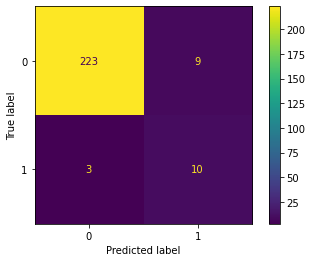

In [274]:
plot_confusion_matrix(model1, X_test, y_test)

In [275]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       232
           1       0.53      0.77      0.62        13

    accuracy                           0.95       245
   macro avg       0.76      0.87      0.80       245
weighted avg       0.96      0.95      0.96       245



In [276]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9510204081632653
0.5263157894736842
0.7692307692307693
0.625


In [401]:
lr_pred = y_pred

### Random Forest

In [277]:
param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 16],
 'min_samples_split': [2, 4, 6, 8, 10],
 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

In [278]:
model2 = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator = model2, param_distributions = param_grid,  
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, scoring='f1')
random_search.fit(X_res, y_res)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=30; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=30; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=30; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=6, n_estimators=20; total t

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.1s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=16, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=16, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=16, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=2, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=6, n_estimators=90; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=40; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=80; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=40, max_f

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=40; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=40; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=16, min_samples_split=4, n_estimators=40; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=8, n_estimators=40; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_fe

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8, 16],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, scoring='f1', verbose=2)

In [279]:
random_search.best_params_

{'n_estimators': 70,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [280]:
model2 = RandomForestClassifier(n_estimators=70, min_samples_split=2, min_samples_leaf=1, bootstrap=False, random_state=42)

In [281]:
model2.fit(X_res, y_res)
y_pred = model2.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


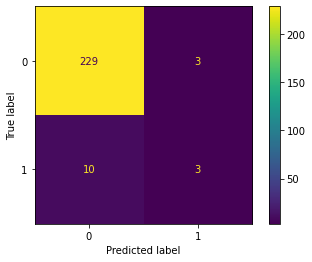

In [282]:
plot_confusion_matrix(model2, X_test, y_test)

In [283]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       232
           1       0.50      0.23      0.32        13

    accuracy                           0.95       245
   macro avg       0.73      0.61      0.64       245
weighted avg       0.93      0.95      0.94       245



In [285]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9469387755102041
0.5
0.23076923076923078
0.3157894736842105


### LSTM

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [287]:
max_words = 3000
max_len = 100
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
seq = tok.texts_to_sequences(X_train)
seq_matrix = pad_sequences(seq, maxlen=max_len)

In [288]:
model3 = Sequential()
model3.add(Embedding(3000, 64, input_length=100))
model3.add(LSTM(64, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

In [289]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 64)           192000    
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense_16 (Dense)            (None, 256)               16640     
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)               

In [290]:
model3.fit(seq_matrix, y_train, batch_size=32, epochs=25)

Epoch 1/25
18/18 [==============================] - 3s 41ms/step - loss: 0.5063 - accuracy: 0.9107
Epoch 2/25
18/18 [==============================] - 1s 43ms/step - loss: 0.2993 - accuracy: 0.9212
Epoch 3/25
18/18 [==============================] - 1s 41ms/step - loss: 0.2337 - accuracy: 0.9212
Epoch 4/25
18/18 [==============================] - 1s 40ms/step - loss: 0.1550 - accuracy: 0.9212
Epoch 5/25
18/18 [==============================] - 1s 42ms/step - loss: 0.1049 - accuracy: 0.9212
Epoch 6/25
18/18 [==============================] - 1s 41ms/step - loss: 0.0772 - accuracy: 0.9212
Epoch 7/25
18/18 [==============================] - 1s 42ms/step - loss: 0.0611 - accuracy: 0.9457
Epoch 8/25
18/18 [==============================] - 1s 41ms/step - loss: 0.0528 - accuracy: 0.9947
Epoch 9/25
18/18 [==============================] - 1s 43ms/step - loss: 0.0334 - accuracy: 1.0000
Epoch 10/25
18/18 [==============================] - 1s 42ms/step - loss: 10.3710 - accuracy: 0.9965
Epoch 11

In [291]:
test_seq = tok.texts_to_sequences(X_test)
test_seq_matrix = pad_sequences(test_seq,maxlen=max_len)

In [292]:
score = model3.evaluate(test_seq_matrix, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

8/8 [==============================] - 0s 18ms/step - loss: 0.7619 - accuracy: 0.9347
Test loss: 0.7618588209152222
Test accuracy: 0.9346938729286194


In [293]:
pred = model3.predict(test_seq_matrix)
y_pred = np.where(pred < 0.5, 0, 1)

8/8 [==============================] - 0s 15ms/step


In [294]:
pred

array([[8.5046255e-14],
       [1.2868248e-12],
       [2.8650089e-09],
       [1.1220759e-16],
       [1.4178213e-06],
       [1.0000000e+00],
       [2.2529641e-18],
       [1.9627115e-13],
       [2.8699280e-15],
       [6.2503725e-01],
       [1.2082565e-15],
       [3.2199193e-07],
       [1.3345997e-15],
       [3.0126563e-07],
       [9.9999726e-01],
       [1.9384892e-08],
       [9.3568295e-12],
       [2.6231408e-08],
       [1.5980887e-09],
       [1.3355243e-11],
       [8.6166690e-10],
       [4.7124200e-11],
       [1.3453028e-08],
       [1.8965315e-10],
       [2.1817090e-13],
       [9.5687610e-06],
       [2.9942067e-12],
       [9.9999994e-01],
       [1.3693230e-10],
       [1.4148434e-12],
       [2.0543911e-09],
       [9.9999905e-01],
       [2.2739189e-02],
       [3.2431893e-02],
       [5.4618908e-05],
       [9.9999982e-01],
       [6.3879072e-18],
       [5.0741477e-08],
       [1.4545577e-06],
       [1.9240762e-01],
       [9.9999982e-01],
       [8.279022

In [295]:
confusion_matrix(y_test, y_pred)

array([[222,  10],
       [  6,   7]], dtype=int64)

In [296]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       232
           1       0.41      0.54      0.47        13

    accuracy                           0.93       245
   macro avg       0.69      0.75      0.72       245
weighted avg       0.94      0.93      0.94       245



In [297]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9346938775510204
0.4117647058823529
0.5384615384615384
0.4666666666666667


In [211]:
lstm_pred = y_pred

### AdaBoost

In [298]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

In [299]:
ada = AdaBoostClassifier(random_state=42)

In [300]:
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.1, 0.2, 0.5, 0.8, 1.0, 10]
}

In [301]:
random_search = RandomizedSearchCV(estimator = ada, param_distributions = param_grid,  n_iter = 100, cv = 3, 
                                   verbose=2, random_state=42, scoring='f1')

In [302]:
random_search.fit(X_res, y_res)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.1s


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.1s
[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.1s
[CV] END .................learning_rate=0.1, n_estimators=20; total time=   0.3s
[CV] END .................learning_rate=0.1, n_estimators=20; total time=   0.3s
[CV] END .................learning_rate=0.1, n_estimators=20; total time=   0.2s
[CV] END .................learning_rate=0.1, n_estimators=30; total time=   0.4s
[CV] END .................learning_rate=0.1, n_estimators=30; total time=   0.4s
[CV] END .................learning_rate=0.1, n_estimators=30; total time=   0.4s
[CV] END .................learning_rate=0.1, n_estimators=40; total time=   0.5s
[CV] END .................learning_rate=0.1, n_estimators=40; total time=   0.6s
[CV] END .................learning_rate=0.1, n_estimators=40; total time=   0.6s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=   0.6s
[CV] END .................le

[CV] END .................learning_rate=0.8, n_estimators=50; total time=   0.8s
[CV] END .................learning_rate=0.8, n_estimators=50; total time=   0.8s
[CV] END .................learning_rate=0.8, n_estimators=60; total time=   0.9s
[CV] END .................learning_rate=0.8, n_estimators=60; total time=   0.9s
[CV] END .................learning_rate=0.8, n_estimators=60; total time=   1.0s
[CV] END .................learning_rate=0.8, n_estimators=70; total time=   1.0s
[CV] END .................learning_rate=0.8, n_estimators=70; total time=   1.0s
[CV] END .................learning_rate=0.8, n_estimators=70; total time=   1.0s
[CV] END .................learning_rate=0.8, n_estimators=80; total time=   1.1s
[CV] END .................learning_rate=0.8, n_estimators=80; total time=   1.1s
[CV] END .................learning_rate=0.8, n_estimators=80; total time=   1.1s
[CV] END .................learning_rate=0.8, n_estimators=90; total time=   1.2s
[CV] END .................le

RandomizedSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.5, 0.8,
                                                          1.0, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, scoring='f1', verbose=2)

In [303]:
res_dict = random_search.best_params_
res_dict

{'n_estimators': 80, 'learning_rate': 1.0}

In [304]:
ada = AdaBoostClassifier(n_estimators = res_dict['n_estimators'], learning_rate = res_dict['learning_rate'], 
                        random_state=42)

In [305]:
ada.fit(X_res, y_res)

AdaBoostClassifier(n_estimators=80, random_state=42)

In [306]:
y_pred = ada.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


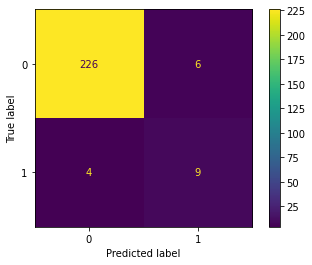

In [307]:
plot_confusion_matrix(ada, X_test, y_test)

In [308]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       232
           1       0.60      0.69      0.64        13

    accuracy                           0.96       245
   macro avg       0.79      0.83      0.81       245
weighted avg       0.96      0.96      0.96       245



In [309]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9591836734693877
0.6
0.6923076923076923
0.6428571428571429


In [503]:
ada_pred = y_pred

### One Class SVM

In [310]:
ocsvm = SVC()

In [311]:
param_grid = {
    'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": np.arange(0.1, 1, 0.1)
}

In [312]:
random_search = RandomizedSearchCV(estimator = ocsvm, param_distributions = param_grid,  n_iter = 100, 
                                   cv = 3, verbose=2, random_state=42, scoring='f1')

In [313]:
random_search.fit(X_res, y_res)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ......C=7, gamma=0.30000000000000004, kernel=linear; total time=   0.2s
[CV] END ......C=7, gamma=0.30000000000000004, kernel=linear; total time=   0.1s
[CV] END ......C=7, gamma=0.30000000000000004, kernel=linear; total time=   0.1s
[CV] END .........................C=2, gamma=0.2, kernel=rbf; total time=   0.2s
[CV] END .........................C=2, gamma=0.2, kernel=rbf; total time=   0.2s
[CV] END .........................C=2, gamma=0.2, kernel=rbf; total time=   0.3s
[CV] END ........................C=8, gamma=0.9, kernel=poly; total time=   0.3s
[CV] END ........................C=8, gamma=0.9, kernel=poly; total time=   0.2s
[CV] END ........................C=8, gamma=0.9, kernel=poly; total time=   0.2s
[CV] END .........................C=9, gamma=0.4, kernel=rbf; total time=   0.2s
[CV] END .........................C=9, gamma=0.4, kernel=rbf; total time=   0.2s
[CV] END .........................C=9, gamma=0

[CV] END ........................C=4, gamma=0.2, kernel=poly; total time=   0.6s
[CV] END ........................C=4, gamma=0.2, kernel=poly; total time=   0.6s
[CV] END ........................C=4, gamma=0.2, kernel=poly; total time=   0.5s
[CV] END .....................C=2, gamma=0.1, kernel=sigmoid; total time=   0.4s
[CV] END .....................C=2, gamma=0.1, kernel=sigmoid; total time=   0.3s
[CV] END .....................C=2, gamma=0.1, kernel=sigmoid; total time=   0.3s
[CV] END .........................C=1, gamma=0.6, kernel=rbf; total time=   0.2s
[CV] END .........................C=1, gamma=0.6, kernel=rbf; total time=   0.5s
[CV] END .........................C=1, gamma=0.6, kernel=rbf; total time=   0.3s
[CV] END .....C=10, gamma=0.7000000000000001, kernel=sigmoid; total time=   0.1s
[CV] END .....C=10, gamma=0.7000000000000001, kernel=sigmoid; total time=   0.1s
[CV] END .....C=10, gamma=0.7000000000000001, kernel=sigmoid; total time=   0.1s
[CV] END ...................

[CV] END ........C=10, gamma=0.30000000000000004, kernel=rbf; total time=   0.2s
[CV] END ........C=10, gamma=0.30000000000000004, kernel=rbf; total time=   0.1s
[CV] END ........C=10, gamma=0.30000000000000004, kernel=rbf; total time=   0.1s
[CV] END ........................C=3, gamma=0.6, kernel=poly; total time=   0.2s
[CV] END ........................C=3, gamma=0.6, kernel=poly; total time=   0.3s
[CV] END ........................C=3, gamma=0.6, kernel=poly; total time=   0.2s
[CV] END .........................C=6, gamma=0.5, kernel=rbf; total time=   0.2s
[CV] END .........................C=6, gamma=0.5, kernel=rbf; total time=   0.2s
[CV] END .........................C=6, gamma=0.5, kernel=rbf; total time=   0.2s
[CV] END ........................C=6, gamma=0.5, kernel=poly; total time=   0.2s
[CV] END ........................C=6, gamma=0.5, kernel=poly; total time=   0.3s
[CV] END ........................C=6, gamma=0.5, kernel=poly; total time=   0.2s
[CV] END ...................

RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=100,
                   param_distributions={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                        'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=42, scoring='f1', verbose=2)

In [314]:
res_dict = random_search.best_params_
res_dict

{'kernel': 'poly', 'gamma': 0.9, 'C': 8}

In [315]:
ocsvm = SVC(C = res_dict['C'], kernel = res_dict['kernel'], gamma=res_dict['gamma'])

In [316]:
ocsvm.fit(X_res, y_res)

SVC(C=8, gamma=0.9, kernel='poly')

In [317]:
y_pred = ocsvm.predict(X_test)

In [318]:
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

In [319]:
y_pred = np.vectorize(lambda x: 0 if x == -1 else x)(y_pred)

In [320]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       232
           1       0.00      0.00      0.00        13

    accuracy                           0.93       245
   macro avg       0.47      0.49      0.48       245
weighted avg       0.90      0.93      0.91       245



In [321]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9346938775510204
0.0
0.0
0.0


In [235]:
res = pd.DataFrame([lr_pred, lstm_pred, ada_pred]).transpose()

In [221]:
res

,0,1,2
0,0,[0],0
1,0,[0],0
2,0,[0],0
3,0,[0],0
4,0,[0],0
...,...,...,...
240,0,[0],0
241,0,[0],0
242,0,[1],0
243,0,[0],0


In [222]:
res[1] = res[1].apply(lambda x: x[0])

In [223]:
res

,0,1,2
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
240,0,0,0
241,0,0,0
242,0,1,0
243,0,0,0


In [224]:
res['total'] = res.mode(axis=1)[0]

In [225]:
res['total']

0      0
1      0
2      0
3      0
4      0
      ..
240    0
241    0
242    0
243    0
244    0
Name: total, Length: 245, dtype: int64

In [226]:
res

,0,1,2,total
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
240,0,0,0,0
241,0,0,0,0
242,0,1,0,0
243,0,0,0,0


In [231]:
confusion_matrix(y_test, res['total'])

array([[228,   4],
       [  4,   9]], dtype=int64)

In [230]:
print(classification_report(y_test, res['total']))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       232
           1       0.69      0.69      0.69        13

    accuracy                           0.97       245
   macro avg       0.84      0.84      0.84       245
weighted avg       0.97      0.97      0.97       245



In [504]:
print(accuracy_score(y_test, ada_pred))
print(precision_score(y_test, ada_pred))
print(recall_score(y_test, ada_pred))
print(f1_score(y_test, ada_pred))

0.9591836734693877
0.6
0.6923076923076923
0.6428571428571429


In [414]:
lr_17 = 'lr_17_model.sav'
lstm_17 = 'lstm_17_model.sav'
ada_17 = 'ada_17_model.sav'
tfidf_17 = 'tfidf_17_model.sav'

In [415]:
pickle.dump(tfidf, open(tfidf_17, 'wb'))
pickle.dump(model1, open(lr_17, 'wb'))
pickle.dump(ada, open(ada_17, 'wb'))

## Attribute 15 Second Layer

In [188]:
df_ext_ones = pd.read_csv('training_datasets/ext_ones_labelled.csv')

In [189]:
df_ext_ones.head()

,words,GT,new_GT
0,The certified locations are audited by externa...,1,0
1,GRI 102-56 see Assurance Report With the excep...,1,0
2,We conducted our assurance engagement in accor...,1,0
3,Tian LLP has provided limited assurance on sel...,1,1
4,And the result will be audited by a third part...,1,0


In [190]:
df_ext_ones['words'] = df_ext_ones['words'].apply(lambda x: pre_processing(x))

In [191]:
X = df_ext_ones['words']
y = df_ext_ones['new_GT']

In [192]:
X = X.apply(lambda x: x.lower())
X

0         the certifi locat audit extern certif organis
1     gri assur report with except auditor legislati...
2     we conduct assur engag accord intern standard ...
3     tian llp provid limit assur select key data re...
4           and result audit parti key refer grant titl
                            ...                        
73    in addit deloitt assur key sustain indic targe...
74    here provid deloitt llps limit assur statement...
75    the scope independ assur data assur share sust...
76              key perform data independ assur deloitt
77    the sustain develop offic team certain data po...
Name: words, Length: 78, dtype: object

In [193]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(X)
X_encoded = pd.DataFrame(x.toarray())

### Train Test Split

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

In [195]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,345,346,347,348,349,350,351,352,353,354
40,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.268317,0.000000,0.000000,0.000000,0.000000,0.000000
47,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.250633,0.000000,0.000000,0.241660,0.000000,0.000000
50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
28,0.000000,0.000000,0.179840,0.000000,0.248334,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.426888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
74,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
45,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.347324,0.000000,0.000000
69,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.159817,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [196]:
y_train.value_counts()

0    29
1    25
Name: new_GT, dtype: int64

In [197]:
y_test.value_counts()

1    12
0    12
Name: new_GT, dtype: int64

### Logistic Regression

In [205]:
model1 = LogisticRegression(random_state=42)
model1.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [206]:
y_pred = model1.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


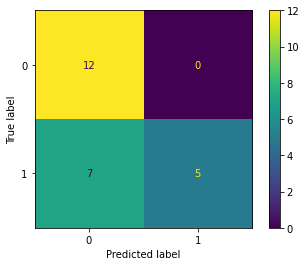

In [207]:
plot_confusion_matrix(model1, X_test, y_test)

In [208]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.7083333333333334
1.0
0.4166666666666667
0.5882352941176471


In [209]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       1.00      0.42      0.59        12

    accuracy                           0.71        24
   macro avg       0.82      0.71      0.68        24
weighted avg       0.82      0.71      0.68        24



In [210]:
lr_pred = y_pred

### Random Forest

In [211]:
param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 16],
 'min_samples_split': [2, 4, 6, 8, 10],
 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

In [212]:
model2 = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator = model2, param_distributions = param_grid,  
                                   n_iter = 100, cv = 3, verbose=2, random_state=42, scoring='f1')
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=30; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=30; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=30; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=80; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=80; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=80; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=6, n_estimators=20; total t

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=16, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=16, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=16, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=2, n_estimators=80; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=2, n_estimators=80; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=16, min_samples_split=2, n_estimators=80; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, 

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=16, min_samples_split=10, n_estimators=70; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=6, n_estimators=90; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=6, n_estimators=90; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=6, n_estimators=90; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_fe

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=80; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=80; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=80; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=8, n_estimators=40; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=16, min_samples_split=8, n_estimators=40; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_feature

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8, 16],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, scoring='f1', verbose=2)

In [213]:
random_search.best_params_

{'n_estimators': 10,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': False}

In [214]:
model2 = RandomForestClassifier(n_estimators=70, min_samples_split=2, min_samples_leaf=1, bootstrap=False, random_state=42)

In [215]:
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


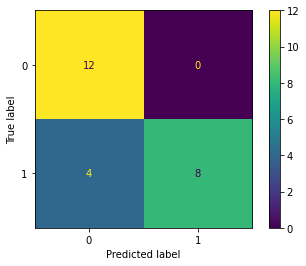

In [216]:
plot_confusion_matrix(model2, X_test, y_test)

In [217]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       1.00      0.67      0.80        12

    accuracy                           0.83        24
   macro avg       0.88      0.83      0.83        24
weighted avg       0.88      0.83      0.83        24



In [218]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8333333333333334
1.0
0.6666666666666666
0.8


### LSTM

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [220]:
max_words = 3000
max_len = 100
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
seq = tok.texts_to_sequences(X_train)
seq_matrix = pad_sequences(seq, maxlen=max_len)

In [221]:
model3 = Sequential()
model3.add(Embedding(3000, 64, input_length=100))
model3.add(LSTM(64, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

In [222]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 64)           192000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_11 (Dense)            (None, 256)               16640     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)               

In [223]:
model3.fit(seq_matrix, y_train, batch_size=32, epochs=25)

Epoch 1/25
2/2 [==============================] - 2s 43ms/step - loss: 0.6933 - accuracy: 0.5185
Epoch 2/25
2/2 [==============================] - 0s 42ms/step - loss: 0.6934 - accuracy: 0.5000
Epoch 3/25
2/2 [==============================] - 0s 41ms/step - loss: 0.6922 - accuracy: 0.5926
Epoch 4/25
2/2 [==============================] - 0s 41ms/step - loss: 0.6917 - accuracy: 0.6481
Epoch 5/25
2/2 [==============================] - 0s 42ms/step - loss: 0.6920 - accuracy: 0.5370
Epoch 6/25
2/2 [==============================] - 0s 40ms/step - loss: 0.6905 - accuracy: 0.6111
Epoch 7/25
2/2 [==============================] - 0s 39ms/step - loss: 0.6913 - accuracy: 0.5556
Epoch 8/25
2/2 [==============================] - 0s 41ms/step - loss: 0.6877 - accuracy: 0.6667
Epoch 9/25
2/2 [==============================] - 0s 40ms/step - loss: 0.6874 - accuracy: 0.5556
Epoch 10/25
2/2 [==============================] - 0s 40ms/step - loss: 0.6861 - accuracy: 0.5926
Epoch 11/25
2/2 [============

In [224]:
test_seq = tok.texts_to_sequences(X_test)
test_seq_matrix = pad_sequences(test_seq,maxlen=max_len)

In [225]:
score = model3.evaluate(test_seq_matrix, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

1/1 [==============================] - 0s 375ms/step - loss: 0.7038 - accuracy: 0.5833
Test loss: 0.7038255333900452
Test accuracy: 0.5833333134651184


In [226]:
pred = model3.predict(test_seq_matrix)
y_pred = np.where(pred < 0.5, 0, 1)

1/1 [==============================] - 0s 223ms/step


In [227]:
pred

array([[0.23147777],
       [0.14721605],
       [0.18310623],
       [0.6943945 ],
       [0.7146118 ],
       [0.34943715],
       [0.20978542],
       [0.275521  ],
       [0.13912372],
       [0.34583515],
       [0.336071  ],
       [0.14108214],
       [0.26996893],
       [0.28023416],
       [0.12923856],
       [0.19194332],
       [0.15961577],
       [0.19507878],
       [0.13810371],
       [0.15852952],
       [0.3919035 ],
       [0.153739  ],
       [0.18198287],
       [0.30860108]], dtype=float32)

In [228]:
confusion_matrix(y_test, y_pred)

array([[12,  0],
       [10,  2]], dtype=int64)

In [229]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        12
           1       1.00      0.17      0.29        12

    accuracy                           0.58        24
   macro avg       0.77      0.58      0.50        24
weighted avg       0.77      0.58      0.50        24



In [230]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.5833333333333334
1.0
0.16666666666666666
0.2857142857142857


In [270]:
lstm_pred = y_pred

### AdaBoost

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

In [232]:
ada = AdaBoostClassifier(random_state=42)

In [233]:
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.1, 0.2, 0.5, 0.8, 1.0, 10]
}

In [234]:
random_search = RandomizedSearchCV(estimator = ada, param_distributions = param_grid,  n_iter = 100, 
                                   cv = 3, verbose=2, random_state=42, scoring='f1')

In [235]:
random_search.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=10; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=20; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=20; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=20; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=30; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=30; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=30; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=40; total time=   0.0s
[CV] END .................learning_rate=0.1, n_estimators=40; total time=   0.0s
[CV] END .................learning_rate=0.1, n_

[CV] END .................learning_rate=0.8, n_estimators=50; total time=   0.0s
[CV] END .................learning_rate=0.8, n_estimators=50; total time=   0.0s
[CV] END .................learning_rate=0.8, n_estimators=50; total time=   0.0s
[CV] END .................learning_rate=0.8, n_estimators=60; total time=   0.1s
[CV] END .................learning_rate=0.8, n_estimators=60; total time=   0.1s
[CV] END .................learning_rate=0.8, n_estimators=60; total time=   0.0s
[CV] END .................learning_rate=0.8, n_estimators=70; total time=   0.1s
[CV] END .................learning_rate=0.8, n_estimators=70; total time=   0.1s
[CV] END .................learning_rate=0.8, n_estimators=70; total time=   0.1s
[CV] END .................learning_rate=0.8, n_estimators=80; total time=   0.1s
[CV] END .................learning_rate=0.8, n_estimators=80; total time=   0.1s
[CV] END .................learning_rate=0.8, n_estimators=80; total time=   0.1s
[CV] END .................le

RandomizedSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.5, 0.8,
                                                          1.0, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, scoring='f1', verbose=2)

In [236]:
res_dict = random_search.best_params_
res_dict

{'n_estimators': 40, 'learning_rate': 0.8}

In [237]:
ada = AdaBoostClassifier(n_estimators = res_dict['n_estimators'], learning_rate = res_dict['learning_rate'], 
                        random_state=42)

In [238]:
ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.8, n_estimators=40, random_state=42)

In [239]:
y_pred = ada.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


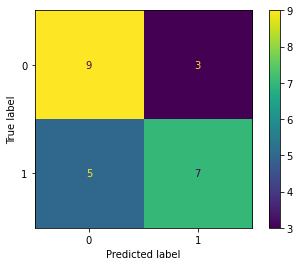

In [240]:
plot_confusion_matrix(ada, X_test, y_test)

In [241]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.70      0.58      0.64        12

    accuracy                           0.67        24
   macro avg       0.67      0.67      0.66        24
weighted avg       0.67      0.67      0.66        24



In [242]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.6666666666666666
0.7
0.5833333333333334
0.6363636363636365


In [243]:
ada_pred = y_pred

### One Class SVM

In [244]:
ocsvm = SVC()

In [245]:
param_grid = {
    'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": np.arange(0.1, 1, 0.1)
}

In [246]:
random_search = RandomizedSearchCV(estimator = ocsvm, param_distributions = param_grid,  n_iter = 100, 
                                   cv = 3, verbose=2, random_state=42, scoring='f1')

In [247]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ......C=7, gamma=0.30000000000000004, kernel=linear; total time=   0.0s
[CV] END ......C=7, gamma=0.30000000000000004, kernel=linear; total time=   0.0s
[CV] END ......C=7, gamma=0.30000000000000004, kernel=linear; total time=   0.0s
[CV] END .........................C=2, gamma=0.2, kernel=rbf; total time=   0.0s
[CV] END .........................C=2, gamma=0.2, kernel=rbf; total time=   0.0s
[CV] END .........................C=2, gamma=0.2, kernel=rbf; total time=   0.0s
[CV] END ........................C=8, gamma=0.9, kernel=poly; total time=   0.0s
[CV] END ........................C=8, gamma=0.9, kernel=poly; total time=   0.0s
[CV] END ........................C=8, gamma=0.9, kernel=poly; total time=   0.0s
[CV] END .........................C=9, gamma=0.4, kernel=rbf; total time=   0.0s
[CV] END .........................C=9, gamma=0.4, kernel=rbf; total time=   0.0s
[CV] END .........................C=9, gamma=0

[CV] END .....................C=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=2, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .........................C=1, gamma=0.6, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.6, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.6, kernel=rbf; total time=   0.0s
[CV] END .....C=10, gamma=0.7000000000000001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=10, gamma=0.7000000000000001, kernel=sigmoid; total time=   0.0s
[CV] END .....C=10, gamma=0.7000000000000001, kernel=sigmoid; total time=   0.0s
[CV] END .........................C=3, gamma=0.6, kernel=rbf; total time=   0.0s
[CV] END .........................C=3, gamma=0.6, kernel=rbf; total time=   0.0s
[CV] END .........................C=3, gamma=0.6, kernel=rbf; total time=   0.0s
[CV] END ...................

[CV] END ........................C=9, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........................C=9, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........................C=9, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....................C=10, gamma=0.4, kernel=linear; total time=   0.0s
[CV] END .....................C=10, gamma=0.4, kernel=linear; total time=   0.0s
[CV] END .....................C=10, gamma=0.4, kernel=linear; total time=   0.0s
[CV] END .....................C=7, gamma=0.4, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=7, gamma=0.4, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=7, gamma=0.4, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=3, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................

RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=100,
                   param_distributions={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                        'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=42, scoring='f1', verbose=2)

In [248]:
res_dict = random_search.best_params_
res_dict

{'kernel': 'rbf', 'gamma': 0.5, 'C': 4}

In [249]:
ocsvm = SVC(C = res_dict['C'], kernel = res_dict['kernel'], gamma=res_dict['gamma'])

In [250]:
ocsvm.fit(X_train, y_train)

SVC(C=4, gamma=0.5)

In [251]:
y_pred = ocsvm.predict(X_test)

In [252]:
y_pred

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1], dtype=int64)

In [253]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8333333333333334
0.9
0.75
0.8181818181818182


In [435]:
y_pred = np.vectorize(lambda x: 0 if x == -1 else x)(y_pred)

In [436]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.90      0.75      0.82        12

    accuracy                           0.83        24
   macro avg       0.84      0.83      0.83        24
weighted avg       0.84      0.83      0.83        24



In [437]:
svm_pred = y_pred

In [438]:
print(accuracy_score(y_test, svm_pred))
print(precision_score(y_test, svm_pred))
print(recall_score(y_test, svm_pred))
print(f1_score(y_test, svm_pred))

0.8333333333333334
0.9
0.75
0.8181818181818182


In [439]:
svc_17 = 'svc_15.pkl'
tfidf_second_15 = 'tfidf_15_2.pkl'

In [440]:
pickle.dump(ocsvm, open(svc_17, 'wb'))
pickle.dump(tfidf, open(tfidf_second_15, 'wb'))